In [54]:
#Imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
#!pip install geopy
#!pip install geopandas
import geopandas as gpd
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from geopy.geocoders import Nominatim
import cartopy.io.shapereader as shpreader

In [18]:
#Data Processing / Loading
### Replace path with .csv path ###
data = pd.read_csv('GP_Alumni_List_Cleaned.csv')

print(data.head())

  Affiliation  PrefClassYear Degrees StateOrProvince         Country
0      Alumni         1983.0     BSc              CO   United States
1      Alumni         1995.0     BSc              CO   United States
2      Alumni         2013.0     MSc             NaN         Bahrain
3      Alumni         1999.0     MSc             NaN  United Kingdom
4      Alumni         1982.0     BSc              OK   United States


In [72]:
#Prep Data for Plotting
data['StateOrProvince'].fillna('Unknown', inplace=True)
data['Country'].fillna('Unknown', inplace=True)
data['Degrees'].fillna('Unknown', inplace=True)
data['PrefClassYear'].fillna(0, inplace=True)
data['Decade'] = data['PrefClassYear'].apply(lambda x: int(x) // 10 * 10 if x != 0 else 0)

# Aggregate the data
country_counts = data.groupby('Country').size()
us_data = data[data['Country'] == 'United States']
state_counts = us_data.groupby('StateOrProvince').size()
degree_counts = data['Degrees'].value_counts()
decade_counts = data.groupby('Decade').size()

In [73]:
#Load world geometry from Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Load your data and count graduates by country

### Replace path with .csv path ###
data = pd.read_csv('GP_Alumni_List_Cleaned.csv')
data['Country'] = data['Country'].str.strip()  #Clean country names if necessary
country_counts = data['Country'].value_counts().reset_index()
country_counts.columns = ['name', 'count']  #Rename columns for easier merging

#Merge this with the world data
world = world.merge(country_counts, how="left", left_on="name", right_on="name")
world['count'].fillna(0, inplace=True)  #Assume no graduates in missing countries

C:\Users\jackh\AppData\Local\Temp\ipykernel_14824\290804924.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [85]:
#Load your data

### Replace path with .csv path ###
data = pd.read_csv('GP_Alumni_List_Cleaned.csv')
data['Country'] = data['Country'].str.strip()

#Replace "United States" with "United States of America" to match the GeoPandas dataset
data['Country'].replace('United States', 'United States of America', inplace=True)

#Load world geometry from Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Count graduates by country and prepare for merging
country_counts = data['Country'].value_counts().reset_index()
country_counts.columns = ['name', 'count']
print(world.loc[world['name'] == 'United States'])

#Merge this with the world data
world = world.merge(country_counts, how="left", on="name")
world['count'].fillna(0, inplace=True)

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []


C:\Users\jackh\AppData\Local\Temp\ipykernel_14824\4075540166.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


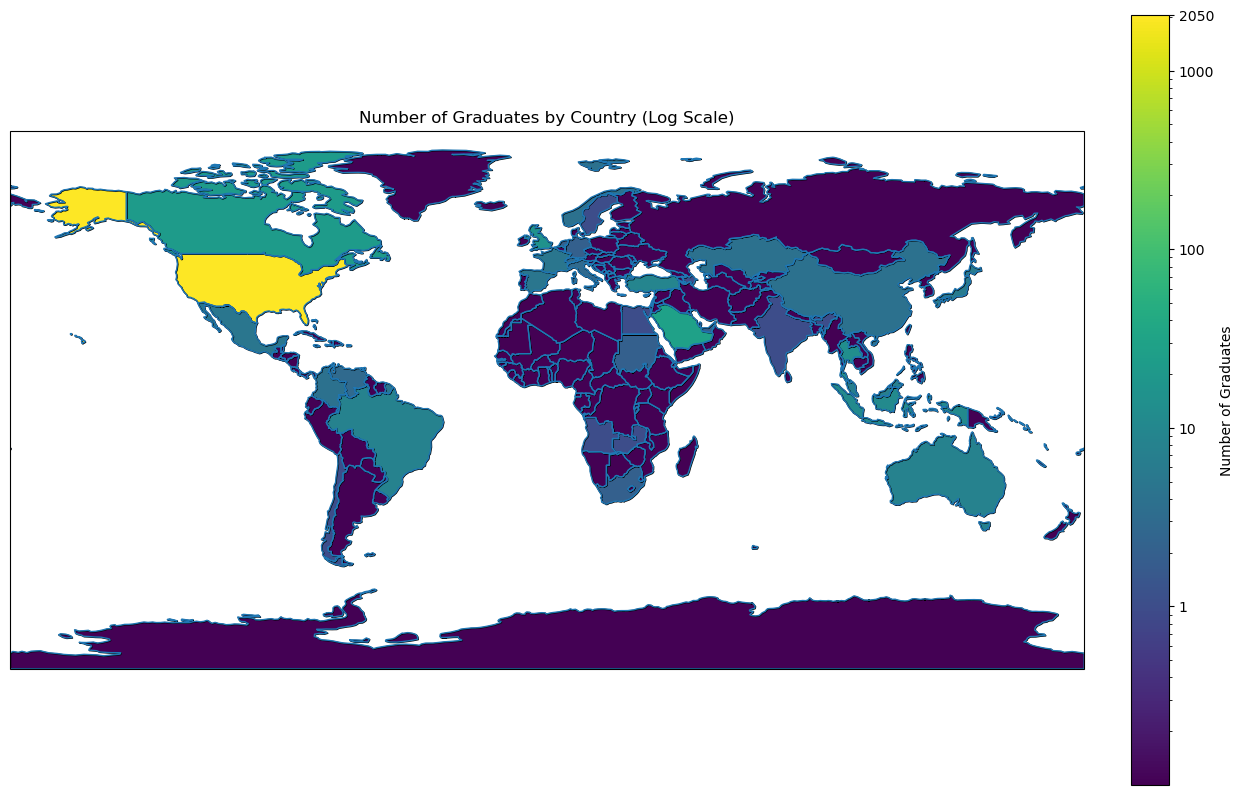

In [75]:
#Plotting the Grads on World Map
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
world.boundary.plot(ax=ax, linewidth=1)

#Set up logarithmic normalization
#Handling zero values by adding a small number to counts where zero would cause an issue
world['count'] = world['count'].replace(0, 0.1)

#Normalize using LogNorm
norm = LogNorm(vmin=world['count'].min(), vmax=world['count'].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(norm=norm, cmap=cmap)

#Plot each country using the 'count' field
for _, row in world.iterrows():
    color = sm.to_rgba(row['count'])
    ax.add_geometries([row['geometry']], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black')

#Add a color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Number of Graduates')

#Adjust color bar to show standard labels instead of log scale
log_ticks = [1, 10, 100, 1000, 2050]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels(log_ticks)

ax.set_title('Number of Graduates by Country (Log Scale)')
plt.show()

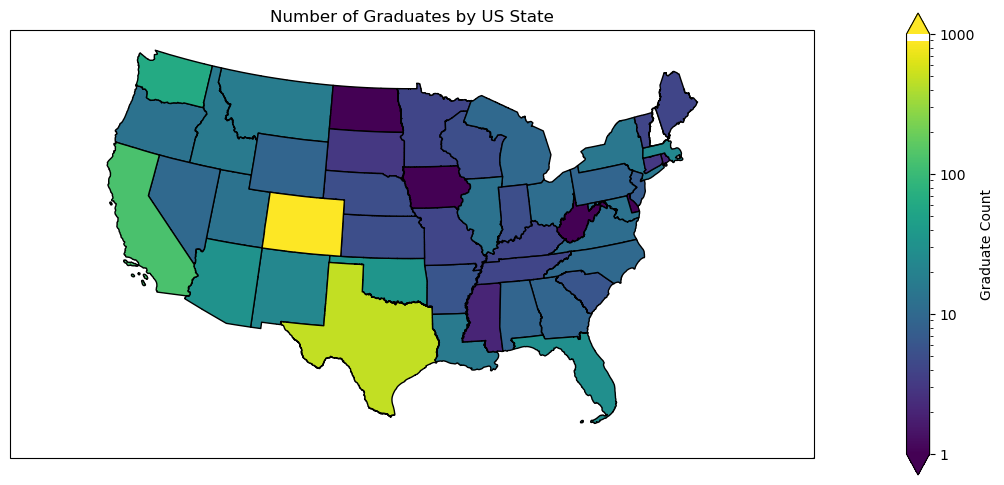

In [82]:
#US Plot of Grads

#Read the shapefile using Geopandas

### Replace with .shp file path ###
gdf = gpd.read_file('tl_2012_us_state.shp')

gdf = gdf.to_crs(epsg=4326)
state_counts = data_exploded[data_exploded['Country'] == 'United States'].groupby('StateOrProvince').size()
state_counts_df = state_counts.reset_index(name='Graduate_Count')
gdf = gdf.merge(state_counts_df, how='left', left_on='STUSPS', right_on='StateOrProvince')
gdf['Graduate_Count'].fillna(0, inplace=True)
gdf['Graduate_Count'] = gdf['Graduate_Count'].astype(int)

#Plotting
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.LambertConformal()})
ax.set_extent([-125, -66.5, 20, 50], crs=ccrs.Geodetic())

#Calculate normalization
norm = LogNorm(vmin=1, vmax=gdf['Graduate_Count'].max())
sm = ScalarMappable(norm=norm, cmap='viridis')
for _, row in gdf.iterrows():
    facecolor = sm.to_rgba(row['Graduate_Count'])
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=facecolor, edgecolor='black')
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.036, pad=0.1, extend='both')
cbar.ax.set_ylabel('Graduate Count')
ax.set_title('Number of Graduates by US State')
log_ticks = [1, 10, 100, 1000]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels(log_ticks)

plt.show()

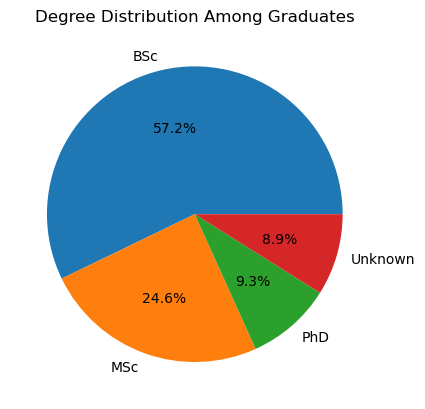

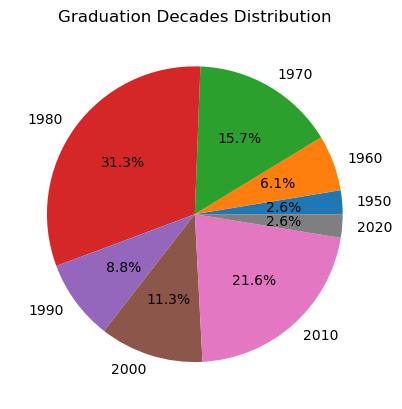

In [78]:
# Degree Distribution
plt.figure()
plt.pie(degree_counts, labels=degree_counts.index, autopct='%1.1f%%')
plt.title('Degree Distribution Among Graduates')
plt.show()

# Decade Distribution
plt.figure()
plt.pie(decade_counts, labels=decade_counts.index, autopct='%1.1f%%')
plt.title('Graduation Decades Distribution')
plt.show()